In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Churn Prediction Project

For this project, we'll use the [Telco customer churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) Kaggle Dataset, that contains characteristics of customers of a Telecommunications company (services they signed up for, customer account information, demographic data) and a column that states if the customer has left within the last month. Our objective will be to predict if a customer will churn. 

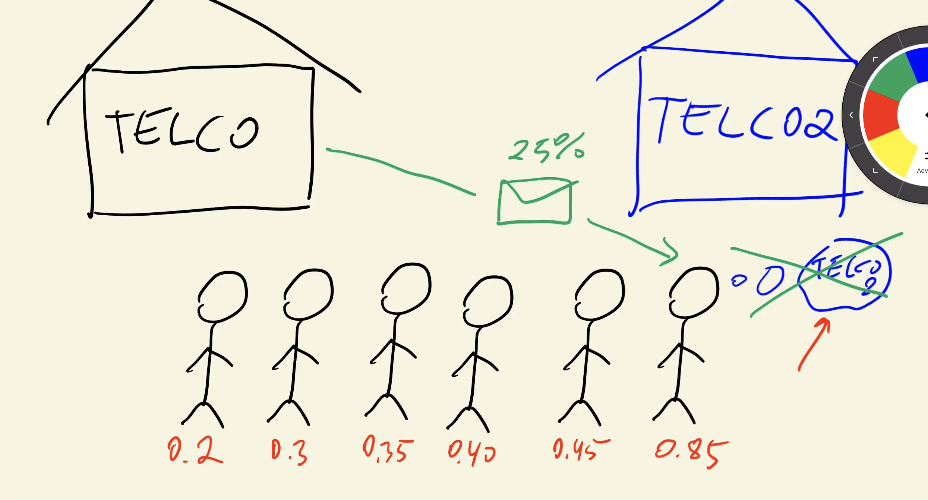

> Why would we be interested in predicting Churn? To not offer a discount to people who won't leave (saving money) and not miss sending offers to people who do need the promotion to stay.

This type of problem is modeled with binary classification (either the customer leaves or stays).

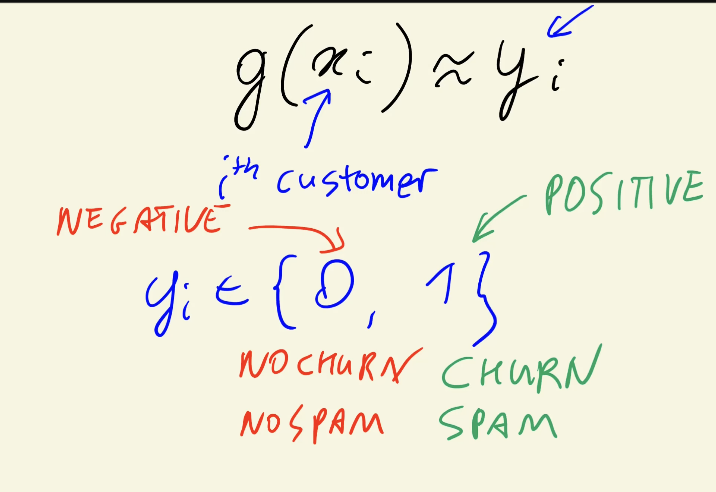

Additionally, to augment the work done in the course we will create a Vertex Pipeline that will make our training code operational (reusable, portable, and perdurable) [[more on Vertex Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction)]. To be able to work with pipelines easily we will practice the use of Python functions from the beginning.

In [ ]:
################## IMPORTS:
import pandas as pd
import numpy as np
    
import matplotlib.pyplot as plt
    
from gcp_python_client_functions.clients import Storage

def read_data_gcs(
    project_id: str, 
    data_gcs_uri: str, 
):
    ##################### CODE:
    stg_obj = Storage(project_id)

    df = pd.read_csv(data_gcs_uri)

    # Base formatting:
    df.columns = df.columns.str.lower()
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
    for c in categorical_columns:
        df[c] = df[c].str.lower()

    return df

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

PROJECT_ID = os.getenv('PROJECT_ID')
BUCKET_NAME = os.getenv('BUCKET_NAME')

In [ ]:
DATA_GCS_URI = f"gs://{BUCKET_NAME}/02_churn_prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = read_data_gcs(PROJECT_ID, DATA_GCS_URI)
df.head()

customerid  gender  seniorcitizen partner dependents  tenure phoneservice  \
0  7590-vhveg  female              0     yes         no       1           no   
1  5575-gnvde    male              0      no         no      34          yes   
2  3668-qpybk    male              0      no         no       2          yes   
3  7795-cfocw    male              0      no         no      45           no   
4  9237-hqitu  female              0      no         no       2          yes   

      multiplelines internetservice onlinesecurity  ... deviceprotection  \
0  no phone service             dsl             no  ...               no   
1                no             dsl            yes  ...              yes   
2                no             dsl            yes  ...               no   
3  no phone service             dsl            yes  ...              yes   
4                no     fiber optic             no  ...               no   

  techsupport streamingtv streamingmovies        contract paperlessbilling  \
0          no          no              no  month-to-month              yes   
1          no          no              no        one year               no   
2          no          no              no  month-to-month              yes   
3         yes          no              no        one year               no   
4          no          no              no  month-to-month              yes   

               paymentmethod monthlycharges  totalcharges churn  
0           electronic check          29.85         29.85    no  
1               mailed check          56.95        1889.5    no  
2               mailed check          53.85        108.15   yes  
3  bank transfer (automatic)          42.30       1840.75    no  
4           electronic check          70.70        151.65   yes  

[5 rows x 21 columns]

In [ ]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [ ]:
df.shape

(7043, 21)

In [ ]:
import pandas as pd

def clean_churn_data(
    dataframe,
):
    df_prepared = dataframe.copy()
    df_prepared.totalcharges = pd.to_numeric(df_prepared.totalcharges, errors='coerce') # coerse: bad non numeric values to NaN
    
    # Handle null values
    df_prepared.totalcharges = df_prepared.totalcharges.fillna(0)

    # Binary label (we'll handle the rest of the variables later):
    df_prepared.churn = (df_prepared.churn == 'yes').astype(int)

    return df_prepared

In [ ]:
df_prepared = clean_churn_data(df)

### Validation Framework
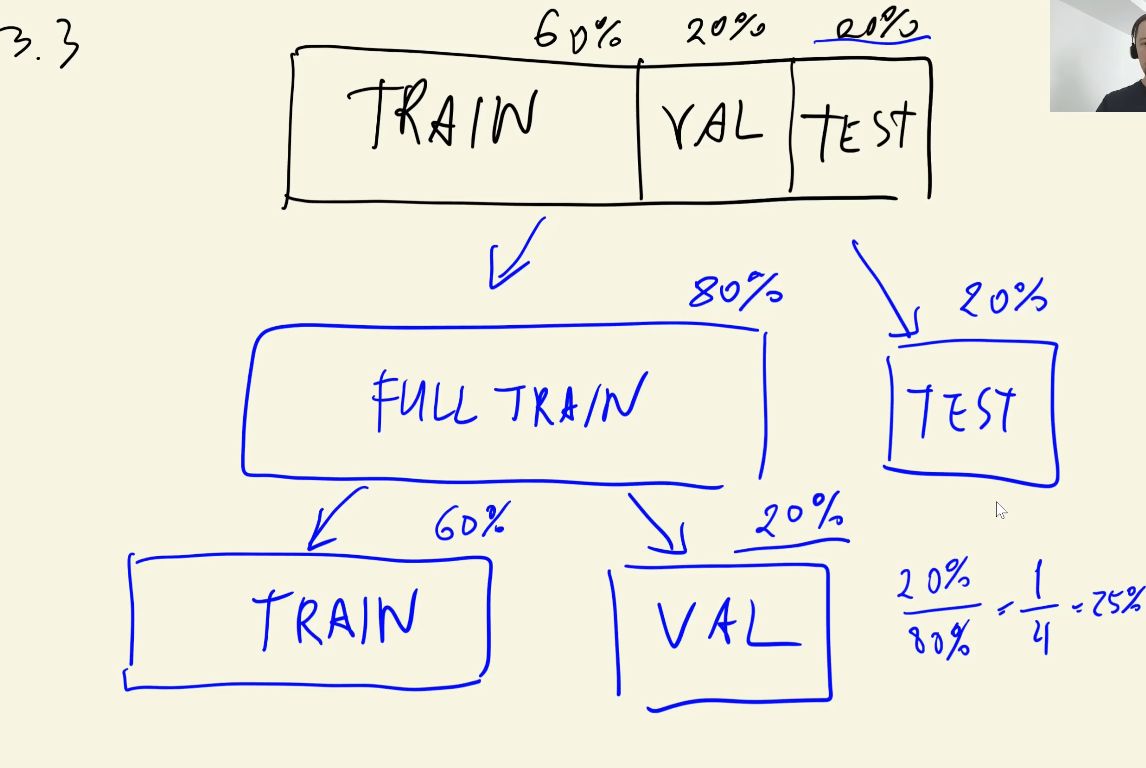

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(
    df,
    test_size: float = 0.2,
    validation_size = 0.2,
    random_state: int = 1,
):
    df_train_full, df_test = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
    )

    # Obtain validation set from the full train:
    train_size = 1 - test_size
    new_validation_size = validation_size/train_size
    
    df_train, df_val = train_test_split(
        df_train_full, 
        test_size=new_validation_size, 
        random_state=random_state,
    )

    df_train_full = df_train_full.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    return df_train_full, df_train, df_val, df_test

In [ ]:
df_train_full, df_train, df_val, df_test = split_data(df_prepared)

### EDA

In [ ]:
df_train_full.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [ ]:
df_train_full.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

Churn rate of 27% on our training dataset.

In [ ]:
# Numerical and categorical variables
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = [
     'gender',
     'seniorcitizen',
     'partner',
     'dependents',
     'phoneservice',
     'multiplelines',
     'internetservice',
     'onlinesecurity',
     'onlinebackup',
     'deviceprotection',
     'techsupport',
     'streamingtv',
     'streamingmovies',
     'contract',
     'paperlessbilling',
     'paymentmethod',
]

In [ ]:
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

Most of them binary or with 3 values.

In [ ]:
churn_female = df_train_full[df_train_full.gender == 'female'].churn.mean()
churn_female

0.27682403433476394

In [ ]:
churn_male = df_train_full[df_train_full.gender == 'male'].churn.mean()
churn_male

0.2632135306553911

In [ ]:
churn_global = df_train_full.churn.mean()
churn_global

0.26996805111821087

In [ ]:
churn_partner = df_train_full[df_train_full.partner == 'yes'].churn.mean()
churn_partner

0.20503330866025166

In [ ]:
churn_no_partner = df_train_full[df_train_full.partner == 'no'].churn.mean()
churn_no_partner

0.3298090040927694

For `gender` the difference in churn is tiny, but for `partner` the difference is big. Perhaps `partner` variable is more important for predicting the churn.

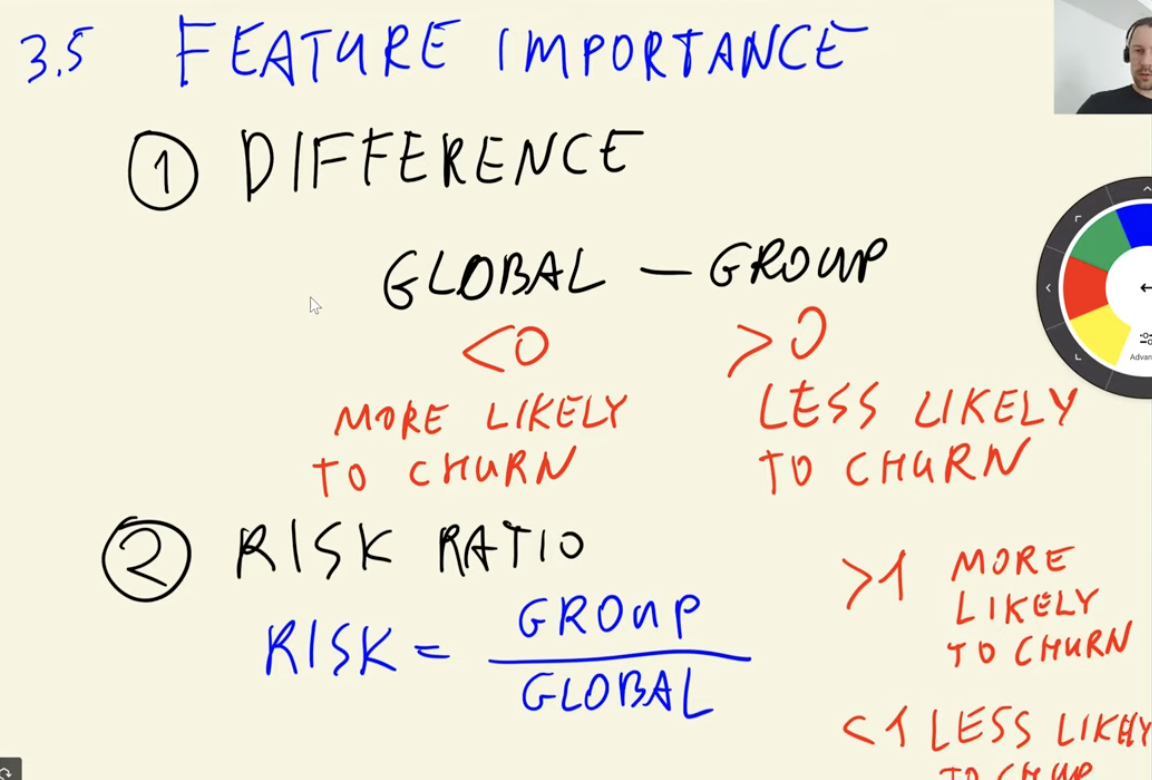

In [ ]:
churn_no_partner/churn_global

1.2216593879412643

Churn rate 22% higher than the global for people without partner.

In [ ]:
churn_partner/churn_global

0.7594724924338315

Churn rate 25% lower that the global for people with partner.

In [ ]:
for col in categorical:
    print(col)
    df_group = df_train_full.groupby(by=col).churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - churn_global
    df_group['risk'] = df_group['mean'] / churn_global
    display(df_group)
    print()
    print()

gender


mean      diff      risk
gender                              
female  0.276824  0.006856  1.025396
male    0.263214 -0.006755  0.974980



seniorcitizen


mean      diff      risk
seniorcitizen                              
0              0.242270 -0.027698  0.897403
1              0.413377  0.143409  1.531208



partner


mean      diff      risk
partner                              
no       0.329809  0.059841  1.221659
yes      0.205033 -0.064935  0.759472



dependents


mean      diff      risk
dependents                              
no          0.313760  0.043792  1.162212
yes         0.165666 -0.104302  0.613651



phoneservice


mean      diff      risk
phoneservice                              
no            0.241316 -0.028652  0.893870
yes           0.273049  0.003081  1.011412



multiplelines


mean      diff      risk
multiplelines                                 
no                0.257407 -0.012561  0.953474
no phone service  0.241316 -0.028652  0.893870
yes               0.290742  0.020773  1.076948



internetservice


mean      diff      risk
internetservice                              
dsl              0.192347 -0.077621  0.712482
fiber optic      0.425171  0.155203  1.574895
no               0.077805 -0.192163  0.288201



onlinesecurity


mean      diff      risk
onlinesecurity                                   
no                   0.420921  0.150953  1.559152
no internet service  0.077805 -0.192163  0.288201
yes                  0.153226 -0.116742  0.567570



onlinebackup


mean      diff      risk
onlinebackup                                     
no                   0.404323  0.134355  1.497672
no internet service  0.077805 -0.192163  0.288201
yes                  0.217232 -0.052736  0.804660



deviceprotection


mean      diff      risk
deviceprotection                                 
no                   0.395875  0.125907  1.466379
no internet service  0.077805 -0.192163  0.288201
yes                  0.230412 -0.039556  0.853480



techsupport


mean      diff      risk
techsupport                                      
no                   0.418914  0.148946  1.551717
no internet service  0.077805 -0.192163  0.288201
yes                  0.159926 -0.110042  0.592390



streamingtv


mean      diff      risk
streamingtv                                      
no                   0.342832  0.072864  1.269897
no internet service  0.077805 -0.192163  0.288201
yes                  0.302723  0.032755  1.121328



streamingmovies


mean      diff      risk
streamingmovies                                  
no                   0.338906  0.068938  1.255358
no internet service  0.077805 -0.192163  0.288201
yes                  0.307273  0.037305  1.138182



contract


mean      diff      risk
contract                                    
month-to-month  0.431701  0.161733  1.599082
one year        0.120573 -0.149395  0.446621
two year        0.028274 -0.241694  0.104730



paperlessbilling


mean      diff      risk
paperlessbilling                              
no                0.172071 -0.097897  0.637375
yes               0.338151  0.068183  1.252560



paymentmethod


mean      diff      risk
paymentmethod                                          
bank transfer (automatic)  0.168171 -0.101797  0.622928
credit card (automatic)    0.164339 -0.105630  0.608733
electronic check           0.455890  0.185922  1.688682
mailed check               0.193870 -0.076098  0.718121

Example conclusion: if we see someone with no partners, no kids, and with a monthly contract they're very likely to churn.

### Feature Importance

#### 1. Mutual information

https://en.wikipedia.org/wiki/Mutual_information

In [ ]:
from sklearn.metrics import mutual_info_score

In [ ]:
def mutual_info_churn(series):
    return mutual_info_score(df_train_full.churn, series)

In [ ]:
df_train_full[categorical].apply(mutual_info_churn).sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

#### 2. Correlation

Linear dependency between variables: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

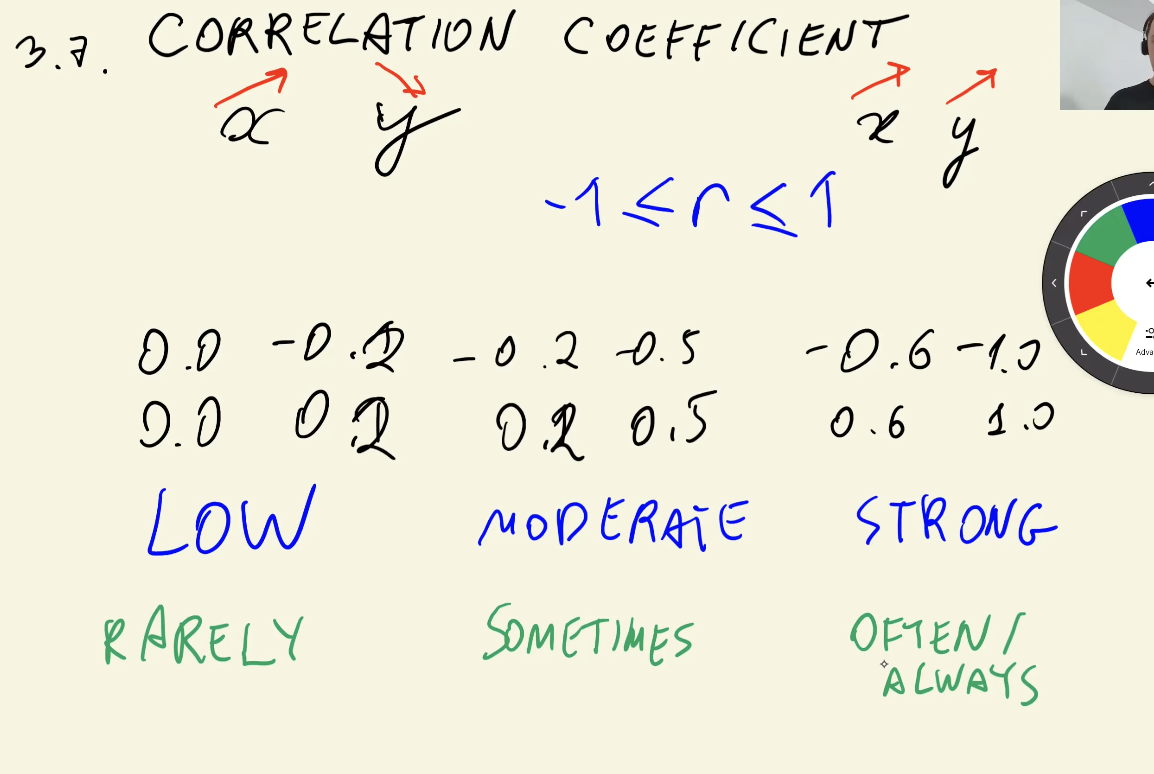

In [ ]:
df_train_full[numerical].corrwith(df_train_full.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [ ]:
df_train_full[df_train_full.tenure <= 2].churn.mean()

0.5953420669577875

In [ ]:
df_train_full[(df_train_full.tenure > 2) & (df_train_full.tenure <= 12)].churn.mean()

0.3994413407821229

In [ ]:
df_train_full[(df_train_full.tenure > 12)].churn.mean()

0.17634908339788277

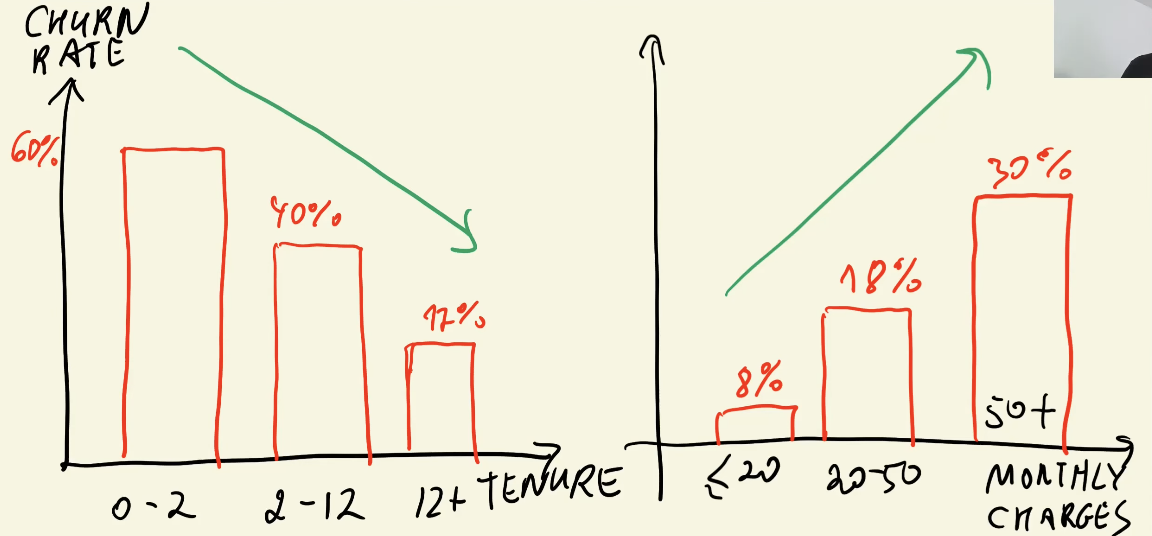

In [ ]:
corr = df_train_full[numerical].corr()
corr

tenure  monthlycharges  totalcharges
tenure          1.000000        0.251072      0.828268
monthlycharges  0.251072        1.000000      0.650913
totalcharges    0.828268        0.650913      1.000000

Total charges is highly correlated with both variables tenure and monthly charges.

In [ ]:
monthly_times_tenure = df_train_full.tenure*df_train_full.monthlycharges
monthly_times_tenure.to_frame().corrwith(df_train_full.totalcharges)

0    0.999561
dtype: float64

We can see how `totalcharges`is an operation of the other two variables. So, we can take it away (also to not confuse our model).

In [ ]:
numerical = ['tenure','monthlycharges']

In [ ]:
corr = df_train_full[numerical].corr()
corr

tenure  monthlycharges
tenure          1.000000        0.251072
monthlycharges  0.251072        1.000000

In [ ]:
numerical

['tenure', 'monthlycharges']

In [ ]:
categorical

['gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod']

## One-hot encoding
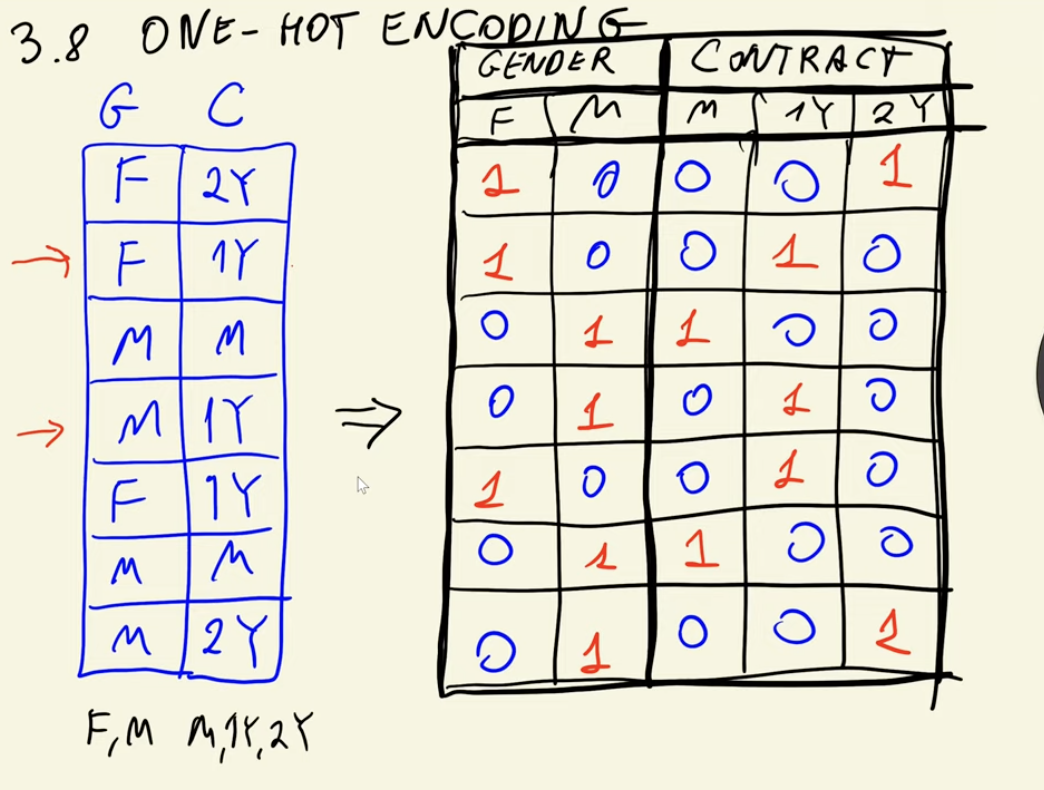

In [ ]:
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import pandas as pd 
import numpy as np

def preprocess_data(
    dataframe,
    cat_features: list,
    num_features: list,
    label: str,
    fit: bool = True,
    mct = None,
):
    y = dataframe[label]
    dataframe = dataframe[cat_features + num_features].copy()
    
    if fit:
        ohe = OneHotEncoder(
            categories='auto',  # Categories per feature
            drop='first', # Whether to drop one of the features
            sparse=True, # Will return sparse matrix if set True
            handle_unknown='error' # Whether to raise an error 
        ) 
        mct = make_column_transformer(
            (ohe, cat_features),
            remainder='passthrough',
        )
        X = mct.fit_transform(dataframe)
    else:
        X = mct.transform(dataframe)
    return X, y, mct

In [ ]:
X_train, y_train, mct = preprocess_data(
    df_train, 
    categorical, 
    numerical,
    'churn',
)

In [ ]:
X_train

array([[  0.  ,   0.  ,   1.  , ...,   0.  ,  72.  , 115.5 ],
       [  1.  ,   0.  ,   0.  , ...,   0.  ,  10.  ,  95.25],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   5.  ,  75.55],
       ...,
       [  1.  ,   0.  ,   1.  , ...,   0.  ,   2.  ,  90.  ],
       [  0.  ,   0.  ,   1.  , ...,   0.  ,  27.  ,  24.5 ],
       [  0.  ,   1.  ,   0.  , ...,   0.  ,   9.  ,  80.85]])

In [ ]:
X_val, y_val, _ = preprocess_data(
    df_val, 
    categorical, 
    numerical,
    label = 'churn',
    fit = False,
    mct = mct,
)

In [ ]:
X_val

array([[ 1.  ,  0.  ,  1.  , ...,  0.  , 71.  , 70.85],
       [ 1.  ,  0.  ,  0.  , ...,  1.  ,  1.  , 20.75],
       [ 1.  ,  0.  ,  0.  , ...,  1.  ,  1.  , 20.35],
       ...,
       [ 1.  ,  0.  ,  0.  , ...,  0.  , 18.  , 55.2 ],
       [ 1.  ,  0.  ,  0.  , ...,  0.  ,  1.  , 93.3 ],
       [ 0.  ,  0.  ,  1.  , ...,  0.  ,  3.  , 95.2 ]])

In [ ]:
list(mct.get_feature_names_out())

['onehotencoder__gender_male',
 'onehotencoder__seniorcitizen_1',
 'onehotencoder__partner_yes',
 'onehotencoder__dependents_yes',
 'onehotencoder__phoneservice_yes',
 'onehotencoder__multiplelines_no phone service',
 'onehotencoder__multiplelines_yes',
 'onehotencoder__internetservice_fiber optic',
 'onehotencoder__internetservice_no',
 'onehotencoder__onlinesecurity_no internet service',
 'onehotencoder__onlinesecurity_yes',
 'onehotencoder__onlinebackup_no internet service',
 'onehotencoder__onlinebackup_yes',
 'onehotencoder__deviceprotection_no internet service',
 'onehotencoder__deviceprotection_yes',
 'onehotencoder__techsupport_no internet service',
 'onehotencoder__techsupport_yes',
 'onehotencoder__streamingtv_no internet service',
 'onehotencoder__streamingtv_yes',
 'onehotencoder__streamingmovies_no internet service',
 'onehotencoder__streamingmovies_yes',
 'onehotencoder__contract_one year',
 'onehotencoder__contract_two year',
 'onehotencoder__paperlessbilling_yes',
 'one

### Logistic Regression (Binary classification)

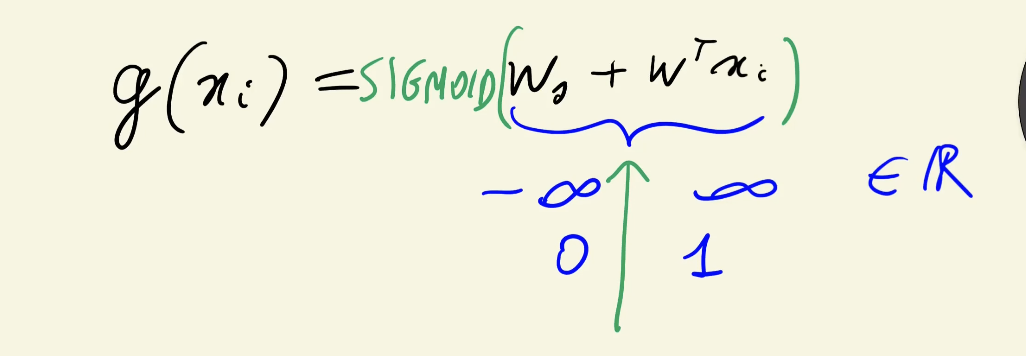

In [ ]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [ ]:
z = np.linspace(-5, 5, 51)

[<matplotlib.lines.Line2D>]

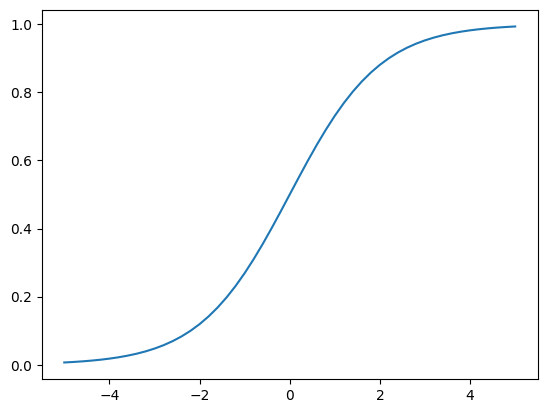

In [ ]:
plt.plot(z, sigmoid(z))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def train_log_reg(
    X_train, 
    y_train,
    X_val,
    y_val,
    threshold: str = 0.5,
):
    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred_val = model.predict_proba(X_val)[:,1]
    churn_decision_val = (y_pred_val >= threshold)

    val_accuracy = (churn_decision_val == y_val).mean()
    cm = confusion_matrix(churn_decision_val, y_val)

    return model, val_accuracy, cm

In [ ]:
model, val_accuracy, cm = train_log_reg(
    X_train, 
    y_train,
    X_val,
    y_val,
)

In [ ]:
print(cm)

[[926 179]
 [ 97 207]]


This tells us that 97 of churn cases are being missed as "no churn", and 179 non-churn clients are sent offers when they were not going to churn. 

In [ ]:
val_accuracy

0.8041163946061036

In [ ]:
model.predict_proba(X_val)

array([[0.99015758, 0.00984242],
       [0.83204961, 0.16795039],
       [0.82040904, 0.17959096],
       ...,
       [0.84688407, 0.15311593],
       [0.18547692, 0.81452308],
       [0.15900624, 0.84099376]])

Explanation:
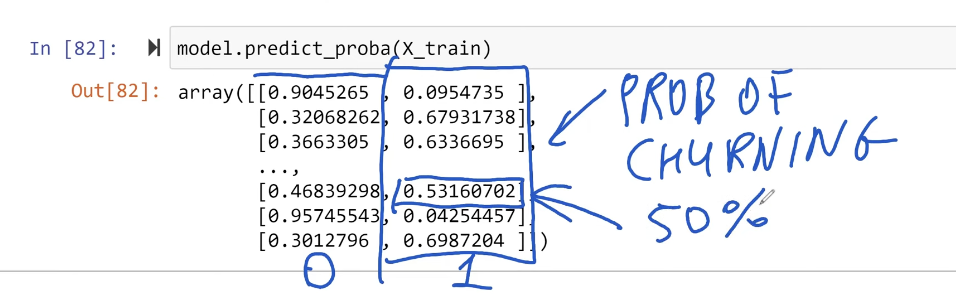

### Model Interpretation

In [ ]:
dict(zip(mct.get_feature_names_out(), model.coef_[0].round(3)))

{'onehotencoder__gender_male': -0.044,
 'onehotencoder__seniorcitizen_1': 0.201,
 'onehotencoder__partner_yes': 0.122,
 'onehotencoder__dependents_yes': -0.084,
 'onehotencoder__phoneservice_yes': -0.535,
 'onehotencoder__multiplelines_no phone service': 0.137,
 'onehotencoder__multiplelines_yes': 0.3,
 'onehotencoder__internetservice_fiber optic': 0.801,
 'onehotencoder__internetservice_no': -0.093,
 'onehotencoder__onlinesecurity_no internet service': -0.093,
 'onehotencoder__onlinesecurity_yes': -0.417,
 'onehotencoder__onlinebackup_no internet service': -0.093,
 'onehotencoder__onlinebackup_yes': -0.091,
 'onehotencoder__deviceprotection_no internet service': -0.093,
 'onehotencoder__deviceprotection_yes': -0.076,
 'onehotencoder__techsupport_no internet service': -0.093,
 'onehotencoder__techsupport_yes': -0.331,
 'onehotencoder__streamingtv_no internet service': -0.093,
 'onehotencoder__streamingtv_yes': 0.173,
 'onehotencoder__streamingmovies_no internet service': -0.093,
 'oneh

Let's train a smaller model:

In [ ]:
small_cat = ['contract']
small_num = ['tenure', 'monthlycharges']

In [ ]:
X_train_small, y_train_small, mct_small = preprocess_data(
    df_train, 
    small_cat, 
    small_num,
    'churn',
)

In [ ]:
X_train_small

array([[  0.  ,   1.  ,  72.  , 115.5 ],
       [  0.  ,   0.  ,  10.  ,  95.25],
       [  0.  ,   0.  ,   5.  ,  75.55],
       ...,
       [  0.  ,   0.  ,   2.  ,  90.  ],
       [  0.  ,   1.  ,  27.  ,  24.5 ],
       [  0.  ,   0.  ,   9.  ,  80.85]])

In [ ]:
X_val_small, y_val_small, _ = preprocess_data(
    df_val, 
    small_cat, 
    small_num,
    label = 'churn',
    fit = False,
    mct = mct_small,
)

In [ ]:
X_val_small

array([[ 0.  ,  1.  , 71.  , 70.85],
       [ 0.  ,  0.  ,  1.  , 20.75],
       [ 0.  ,  0.  ,  1.  , 20.35],
       ...,
       [ 0.  ,  0.  , 18.  , 55.2 ],
       [ 0.  ,  0.  ,  1.  , 93.3 ],
       [ 0.  ,  0.  ,  3.  , 95.2 ]])

In [ ]:
list(mct_small.get_feature_names_out())

['onehotencoder__contract_one year',
 'onehotencoder__contract_two year',
 'remainder__tenure',
 'remainder__monthlycharges']

In [ ]:
model_small = LogisticRegression()
model_small.fit(X_train_small, y_train)

LogisticRegression()

In [ ]:
w0 = model_small.intercept_[0]
w0

-1.5097619153948012

In [ ]:
w = model_small.coef_[0]
w

array([-0.97350524, -1.87174324, -0.03654085,  0.02755775])

In [ ]:
dict(zip(mct_small.get_feature_names_out(), w.round(3)))

{'onehotencoder__contract_one year': -0.974,
 'onehotencoder__contract_two year': -1.872,
 'remainder__tenure': -0.037,
 'remainder__monthlycharges': 0.028}

In [ ]:
# Customer with a monthly contract, 5 months tenure and pay 50usd per month
prob = sigmoid(-1.5 + 0*(-0.974) + 0*(-1.872) + 5*(-0.037) + 50*0.028)
print('Probability of churning:',prob)

Probability of churning: 0.4292283881055083


### Using the model

In [ ]:
X_train_full, y_train_full, mct = preprocess_data(
    df_train_full, 
    categorical, 
    numerical,
    'churn',
)

In [ ]:
X_test, y_test, _ = preprocess_data(
    df_test, 
    categorical, 
    numerical,
    label = 'churn',
    fit = False,
    mct = mct,
)

In [ ]:
model, val_accuracy, cm = train_log_reg(
    X_train_full, 
    y_train_full,
    X_test,
    y_test,
)

In [ ]:
val_accuracy

0.8062455642299503

In [ ]:
print(cm)

[[938 150]
 [123 198]]


Example:

In [ ]:
customer = df_test[df_test.customerid == '8879-zkjof']
customer.T

0
customerid                       8879-zkjof
gender                               female
seniorcitizen                             0
partner                                  no
dependents                               no
tenure                                   41
phoneservice                            yes
multiplelines                            no
internetservice                         dsl
onlinesecurity                          yes
onlinebackup                             no
deviceprotection                        yes
techsupport                             yes
streamingtv                             yes
streamingmovies                         yes
contract                           one year
paperlessbilling                        yes
paymentmethod     bank transfer (automatic)
monthlycharges                        79.85
totalcharges                        3320.75
churn                                     0

In [ ]:
X_cutomer, y_customer, _ = preprocess_data(
    customer, 
    categorical, 
    numerical,
    label = 'churn',
    fit = False,
    mct = mct,
)

print('The predicted probability of this customer to churn is %.2f/100'%((model.predict_proba(X_cutomer)[:,1][0])*100))

The predicted probability of this customer to churn is 7.37/100


In [ ]:
# Did the customer actually churned?
y_customer[0]==1

False